In [3]:
import icepyx as ipx
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import xarray as xr
%matplotlib inline
#%matplotlib widget
from tqdm import tqdm
from scipy.stats import norm

In [33]:
import satsearch
# print(satsearch.__version__)
# print(satsearch.config.API_URL)
from satsearch import Search
import geopandas as gpd
import ast
import pandas as pd
import geoviews as gv
import hvplot.pandas
from ipywidgets import interact
from IPython.display import display, Image
import intake # if you've installed intake-STAC, it will automatically import alongside intake
import boto3
import rasterio as rio
import rioxarray as rxr
from rasterio.session import AWSSession
from rasterio.plot import show
from dask.utils import SerializableLock
import hvplot.xarray
from pyproj import Proj, transform
import earthpy.plot as ep
from metpy.interpolate import cross_section

# Download Data

In [4]:
short_name = 'ATL03'
# PineIsland
spatial_extent = [-101.8,-75.23,-100.50,-74.80]
#date_range = ['2019-01-01','2019-01-30']
date_range = ['2019-04-16','2019-04-16']

In [5]:
region_a = ipx.Query(short_name, spatial_extent, date_range)

In [6]:
region_a.avail_granules(ids=True)

[['ATL03_20190416005803_02710310_005_01.h5',
  'ATL03_20190416005803_02710310_005_01.h5']]

In [7]:
earthdata_uid = 'mengnanzhao'
email = 'mzhao@aer.com'
region_a.earthdata_login(earthdata_uid, email)

Earthdata Login password: ········


In [8]:
region_a.order_granules()

Total number of data order requests is  1  for  2  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000003709153
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [9]:
region_a.granules.orderIDs

['5000003709153']

In [10]:
path = './data/'
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000003709153 of  1  order(s) is downloaded.
Download complete


In [12]:
! h5ls ./data/processed_ATL03_20190416005803_02710310_005_01.h5/gt2l/heights

delta_time               Dataset {327878/Inf}
dist_ph_across           Dataset {327878/Inf}
dist_ph_along            Dataset {327878/Inf}
h_ph                     Dataset {327878/Inf}
lat_ph                   Dataset {327878/Inf}
lon_ph                   Dataset {327878/Inf}
pce_mframe_cnt           Dataset {327878/Inf}
ph_id_channel            Dataset {327878/Inf}
ph_id_count              Dataset {327878/Inf}
ph_id_pulse              Dataset {327878/Inf}
quality_ph               Dataset {327878/Inf}
signal_conf_ph           Dataset {327878/Inf, 5/Inf}


# Read a full file 

In [13]:
def ATL03_to_xarray(path):
    dataset_list = []
    for track in ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']:
        ds = xr.open_dataset(
            filename_or_obj=path,
            group=f"{track}/heights",
        )
        ds['gt_id'] = [track]
        ds['delta_time'] = np.arange(len(ds.delta_time.data))
        ds = ds.rename({'delta_time': 'id_point'})
        dataset_list.append(ds)
    dataset = xr.concat(dataset_list, dim = 'gt_id')
    return dataset

In [14]:
#ds = ATL03_to_xarray("/tmp/test/processed_ATL03_20190115051807_02710210_005_01.h5")
ds = ATL03_to_xarray("./data/processed_ATL03_20190416005803_02710310_005_01.h5")
ds

<xarray.Dataset>
Dimensions:         (id_point: 416516, gt_id: 6, ds_surf_type: 5)
Coordinates:
  * id_point        (id_point) int64 0 1 2 3 4 ... 416512 416513 416514 416515
  * gt_id           (gt_id) <U4 'gt1l' 'gt1r' 'gt2l' 'gt2r' 'gt3l' 'gt3r'
    lat_ph          (gt_id, id_point) float64 -74.8 -74.8 -74.8 ... nan nan nan
    lon_ph          (gt_id, id_point) float64 -101.3 -101.3 -101.3 ... nan nan
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (gt_id, id_point) float32 3.404e+03 3.404e+03 ... nan nan
    dist_ph_along   (gt_id, id_point) float32 0.2311 0.2328 0.2307 ... nan nan
    h_ph            (gt_id, id_point) float32 -27.62 -27.99 -27.56 ... nan nan
    pce_mframe_cnt  (gt_id, id_point) float64 8.831e+08 8.831e+08 ... nan nan
    ph_id_channel   (gt_id, id_point) float64 70.0 7.0 68.0 65.0 ... nan nan nan
    ph_id_count     (gt_id, id_point) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    ph_id_pulse     (gt_id, id_point) float64 20.0 20.0 20.0 ... nan nan nan
    quality_ph      (gt_id, id_point) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    signal_conf_ph  (gt_id, id_point, ds_surf_type) float64 4.0 4.0 ... nan nan
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

In [15]:
# save to nc
#ds.to_netcdf('PI_20190115.nc')
ds.to_netcdf('./data/PI_20190416.nc')

<ipython-input-15-8907275485f1>:3: SerializationWarning: saving variable pce_mframe_cnt with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf('./data/PI_20190416.nc')
<ipython-input-15-8907275485f1>:3: SerializationWarning: saving variable ph_id_channel with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf('./data/PI_20190416.nc')
<ipython-input-15-8907275485f1>:3: SerializationWarning: saving variable ph_id_count with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf('./data/PI_20190416.nc')
<ipython-input-15-8907275485f1>:3: SerializationWarning: saving variable ph_id_pulse with floating point data as an integer dtype without any _FillValue to use for NaNs
  ds.to_netcdf('./data/PI_20190416.nc')
<ipython-input-15-8907275485f1>:3: SerializationWarning: saving variable quality_ph with floating point data as an integer dtype without any _FillValue to use 

In [3]:
# read nc
ds = xr.open_dataset("./data/PI_20190115.nc")

In [4]:
ds

<xarray.Dataset>
Dimensions:         (id_point: 378909, gt_id: 6, ds_surf_type: 5)
Coordinates:
  * id_point        (id_point) int64 0 1 2 3 4 ... 378905 378906 378907 378908
  * gt_id           (gt_id) object 'gt1l' 'gt1r' 'gt2l' 'gt2r' 'gt3l' 'gt3r'
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (gt_id, id_point) float32 ...
    dist_ph_along   (gt_id, id_point) float32 ...
    h_ph            (gt_id, id_point) float32 ...
    lat_ph          (gt_id, id_point) float64 ...
    lon_ph          (gt_id, id_point) float64 ...
    pce_mframe_cnt  (gt_id, id_point) uint32 ...
    ph_id_channel   (gt_id, id_point) uint8 ...
    ph_id_count     (gt_id, id_point) int8 ...
    ph_id_pulse     (gt_id, id_point) uint8 ...
    quality_ph      (gt_id, id_point) int8 ...
    signal_conf_ph  (gt_id, id_point, ds_surf_type) int8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

### selecting one track and simple plotting

In [16]:
gt2l = ds.sel(gt_id='gt2l')
gt2l = gt2l.where(gt2l.quality_ph == 0, drop=True)
gt2l

<xarray.Dataset>
Dimensions:         (id_point: 323789, ds_surf_type: 5)
Coordinates:
  * id_point        (id_point) int64 0 1 2 3 4 ... 327874 327875 327876 327877
    gt_id           <U4 'gt2l'
    lat_ph          (id_point) float64 -74.8 -74.8 -74.8 ... -75.23 -75.23
    lon_ph          (id_point) float64 -101.4 -101.4 -101.4 ... -101.6 -101.6
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (id_point) float32 33.91 33.91 33.91 ... 35.78 35.78 35.78
    dist_ph_along   (id_point) float32 0.5496 0.55 0.5516 ... 19.89 19.89 19.89
    h_ph            (id_point) float32 -27.72 -27.8 -28.1 ... 44.65 44.94 45.19
    pce_mframe_cnt  (id_point) float64 8.828e+08 8.828e+08 ... 8.828e+08
    ph_id_channel   (id_point) float64 31.0 92.0 34.0 29.0 ... 83.0 92.0 24.0
    ph_id_count     (id_point) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ph_id_pulse     (id_point) float64 136.0 136.0 136.0 ... 77.0 77.0 77.0
    quality_ph      (id_point) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    signal_conf_ph  (id_point, ds_surf_type) float64 4.0 4.0 4.0 ... 4.0 4.0 4.0
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

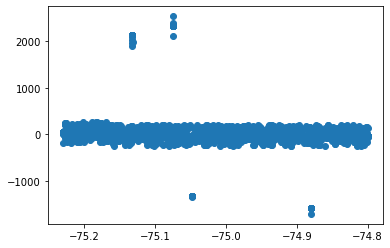

In [17]:
plt.scatter(x=gt2l.lat_ph.data, y=gt2l.h_ph.data)

# Select "ocean" photons

In [18]:
def ocn_sec(ds):
    '''
    This function returns dataset containing ATL03 classified as ocean area (accuracy not well?)
    with confidence level in ocean column larger than 2 (medium and high)
    with quality <2 nominal + possible after pulse)
    '''
    ocn_ds = ds.where( (ds['signal_conf_ph'][:,2]>2) & (ds['quality_ph']<2) , drop=True)
    return ocn_ds

# Height Estimates & Photon density

In [19]:
from math import sin, cos, sqrt, atan2, radians
def distance(lon1,lat1,lon2,lat2):
    '''
    This function calculates distance between two coordinates
    return distance in meter
    '''
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dist = R * c * 1000
    return dist

def ssh_estimate(ocn_ds,num_photon,binsize):
    '''
    This function returns ssh estimates on a running section 
    section length is associated with the number of photons chosen
    returns height estimates based on the histogram and mean latitude in the chosen photons
    '''
    h_value = [];
    h_err = [];
    lon_ave = [];
    lat_ave = [];
    ph_density = [];
    
    for i in range(0,len(ocn_ds['lat_ph']),num_photon):
    #for i in range(0,len(ocn_ds['lat_ph']),10):
        h = ocn_ds['h_ph'][i:i+num_photon]
        # histogram and the representative values
        h_hist = np.histogram(h,bins=np.arange(-100,100,binsize))
        h_value = np.append(h_value, np.mean(h_hist[1][np.where(h_hist[0]==h_hist[0].max())]))
        # std error for uncertainties
        h_err = np.append(h_err, np.std(h)/np.sqrt(num_photon))
        # mean lat/lon
        lats = ocn_ds['lat_ph'][i:i+num_photon]
        lons = ocn_ds['lon_ph'][i:i+num_photon]
        lon_ave = np.append(lon_ave, np.mean(lons))
        lat_ave = np.append(lat_ave, np.mean(lats))
        
        # photon density
        latmax,latmin = lats.max(),lats.min()
        lonmax,lonmin = lons.max(),lons.min() 
        trans_distance = distance(lonmax,latmax,lonmin,latmin)
        ph_density.append(num_photon/trans_distance*100)
        ocean_class = [i<45 for i in ph_density]
        
    # write results into xarray dataset
    ds = xr.Dataset(
        data_vars=dict(
            h_estimate=(["x"], h_value),
            h_err=(["x"], h_err),
            ph_dens=(['x'], ph_density),
            ocean_class=(['x'], ocean_class),
            ),
        coords=dict(
            lon=(["x"], lon_ave),
            lat=(["x"], lat_ave),
            ),
        
        attrs=dict(description="height estimated from histogram"),
        )
    return ds

# PineIsland, 2019/01/15

In [20]:
ssh_dset_dict = {}
ocn_dset_dict = {}
for track in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:
    ocn_ds = ocn_sec(ds.sel(gt_id=track))
    ssh = ssh_estimate(ocn_ds,50,0.02)
    ssh_dset_dict[track] = ssh
    ocn_dset_dict[track] = ocn_ds

In [21]:
ocn_dset_dict

{'gt1l': <xarray.Dataset>
 Dimensions:         (id_point: 365591, ds_surf_type: 5)
 Coordinates:
   * id_point        (id_point) int64 0 2 3 4 5 ... 400143 400144 400145 400146
     gt_id           <U4 'gt1l'
     lat_ph          (id_point) float64 -74.8 -74.8 -74.8 ... -75.23 -75.23
     lon_ph          (id_point) float64 -101.3 -101.3 -101.3 ... -101.5 -101.5
 Dimensions without coordinates: ds_surf_type
 Data variables:
     dist_ph_across  (id_point) float32 3.404e+03 3.404e+03 ... 3.406e+03
     dist_ph_along   (id_point) float32 0.2311 0.2307 0.2311 ... 19.36 19.36
     h_ph            (id_point) float32 -27.62 -27.56 -27.64 ... 33.86 33.86
     pce_mframe_cnt  (id_point) float64 8.831e+08 8.831e+08 ... 8.831e+08
     ph_id_channel   (id_point) float64 70.0 68.0 65.0 1.0 ... 64.0 9.0 2.0 68.0
     ph_id_count     (id_point) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     ph_id_pulse     (id_point) float64 20.0 20.0 20.0 20.0 ... 134.0 134.0 134.0
     quality_ph      (id_poi

## figure: histogram over an ocean area

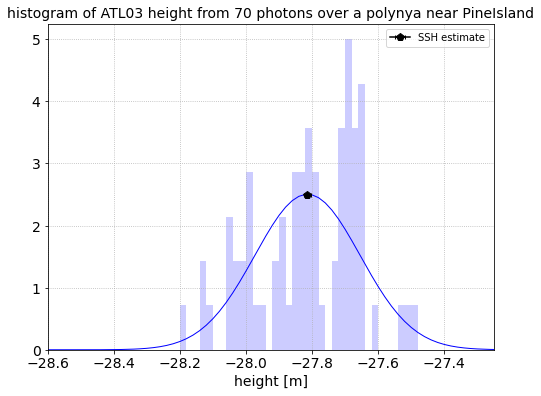

In [22]:
# histogram over an ocean area looks like:
i = 2000; num_photon=70; track = 'gt2l';
h = ocn_dset_dict[track]['h_ph'][i:i+num_photon]
# Fit a normal distribution to the data:
# mean and standard deviation
mu, std = norm.fit(h) 
# Plot the PDF.
x = np.arange(-30, -26, 0.02)
p = norm.pdf(x, mu, std)

fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(labelsize=14)
ax.plot(x, p, 'b', linewidth=1)
ax.errorbar(mu, p[np.where(x>=mu)[0].min()], xerr=ssh['h_err'][int(np.floor(i/70))], marker='p', markersize=8, capsize=2,color='k',label='SSH estimate')
# histogram and the representative values
h_hist = plt.hist(h,bins=np.arange(-30,-26,0.02),density=True, alpha=0.2, color='b',rwidth=3)
plt.xlim(-28.6,-27.25)
plt.grid(linestyle=':')
plt.xlabel('height [m]',fontsize=14)
plt.title('histogram of ATL03 height from 70 photons over a polynya near PineIsland',fontsize=14)
plt.legend()

## Height along one beam and photon class

In [23]:
ssh = ssh_dset_dict['gt2l']
ssh

<xarray.Dataset>
Dimensions:      (x: 6008)
Coordinates:
    lon          (x) float64 -101.4 -101.4 -101.4 ... -101.6 -101.6 -101.6
    lat          (x) float64 -74.8 -74.8 -74.8 -74.8 ... -75.23 -75.23 -75.23
Dimensions without coordinates: x
Data variables:
    h_estimate   (x) float64 -27.8 -27.66 -27.75 -27.8 ... 45.1 45.06 45.05
    h_err        (x) float64 0.02265 0.01953 0.01918 ... 0.1168 0.01909 0.01828
    ph_dens      (x) float64 546.5 593.3 590.0 ... 1.19e+03 1.02e+03 3.736e+06
    ocean_class  (x) bool False False False False ... False False False False
Attributes:
    description:  height estimated from histogram

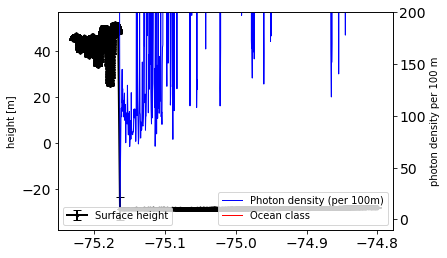

In [24]:
ocean = ssh['ph_dens'].where(ssh['ocean_class']==1,np.nan)

fig, ax1 = plt.subplots()

ax1.tick_params(labelsize=14)
ax1.errorbar(ssh['lat'], ssh['h_estimate'], yerr=ssh['h_err'], marker='.', color='k',markersize=5, capsize=4,linewidth=2,label='Surface height')
#ax1.set_xlim(-75.25,-74.8)
ax1.set_ylabel('height [m]')

ax2 = ax1.twinx() 
ax2.tick_params(labelsize=14)
ax2.plot(ssh['lat'], ssh['ph_dens'],color='b',linewidth=1,label='Photon density (per 100m)')
ax2.plot(ssh['lat'], ocean,color='r',linewidth=1,label='Ocean class')
ax2.set_ylim(-10,200)
ax2.set_ylabel('photon density per 100 m')

ax1.legend(loc='lower left')
ax2.legend()

plt.show()

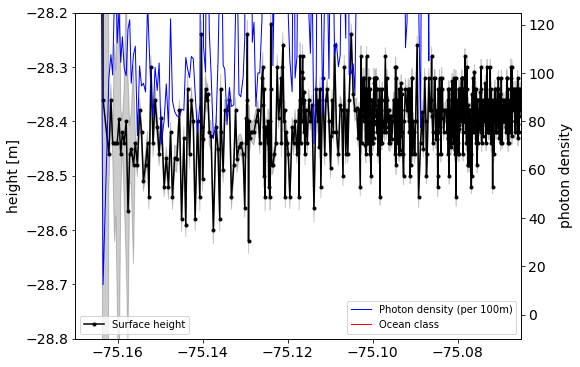

In [25]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.tick_params(labelsize=14)
#ax1.errorbar(ssh['lat'], ssh['h_estimate'], yerr=ssh['h_err'], marker='.', color='k',markersize=5, capsize=4,linewidth=2,label='Surface height')
ax1.fill_between(ssh['lat'], ssh['h_estimate']-ssh['h_err'], ssh['h_estimate']+ssh['h_err'],color='k',alpha=0.2)
ax1.plot(ssh['lat'], ssh['h_estimate'],'o-',markersize=3,color='k', label='Surface height')
ax1.set_xlim(-75.17,-75.065)
ax1.set_ylim(-28.8,-28.2)
ax1.set_ylabel('height [m]',fontsize=14)

ax2 = ax1.twinx() 
ax2.tick_params(labelsize=14)
ax2.plot(ssh['lat'], ssh['ph_dens'],color='b',linewidth=1,label='Photon density (per 100m)')
ax2.plot(ssh['lat'], ocean,color='r',linewidth=1,label='Ocean class')
ax2.set_ylim(-10,125)
ax2.set_ylabel('photon density', fontsize=14)

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

plt.show()
# fig.savefig("ssh_ph_dens.png", dpi=300)

# function: Detrend 

In [45]:
from scipy import signal

In [68]:
def detrend_dim(da,dim):
    '''
    This function detrend a dataarray along a single dimension
    Note that mean value is also removed
    '''
    p = da.polyfit(dim=dim, deg=1, skipna=True)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)

    return da - fit

In [79]:
ssh['lat']

<xarray.DataArray 'lat' (x: 6008)>
array([-74.8000491 , -74.80012872, -74.80019935, ..., -75.22987887,
       -75.22991863, -75.22994038])
Coordinates:
    lon      (x) float64 -101.4 -101.4 -101.4 -101.4 ... -101.6 -101.6 -101.6
    lat      (x) float64 -74.8 -74.8 -74.8 -74.8 ... -75.23 -75.23 -75.23 -75.23
Dimensions without coordinates: x

In [86]:
# check; note that ssh is not "clean" --- the southern latitudes are not likely to be ocean surface
# I choose ssh['h_estimate']<-20 to get a clear ssh surface
ssh1 = ssh.where(ssh['h_estimate']<-20, drop=True)

In [87]:
ssh1

<xarray.Dataset>
Dimensions:      (x: 4658)
Coordinates:
    lon          (x) float64 -101.4 -101.4 -101.4 ... -101.6 -101.6 -101.6
    lat          (x) float64 -74.8 -74.8 -74.8 -74.8 ... -75.16 -75.16 -75.16
Dimensions without coordinates: x
Data variables:
    h_estimate   (x) float64 -27.8 -27.66 -27.75 -27.8 ... -28.36 -28.46 -28.36
    h_err        (x) float64 0.02265 0.01953 0.01918 ... 0.02828 0.06672 4.884
    ph_dens      (x) float64 546.5 593.3 590.0 707.6 ... 99.18 107.6 97.75 12.38
    ocean_class  (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 1.0
Attributes:
    description:  height estimated from histogram

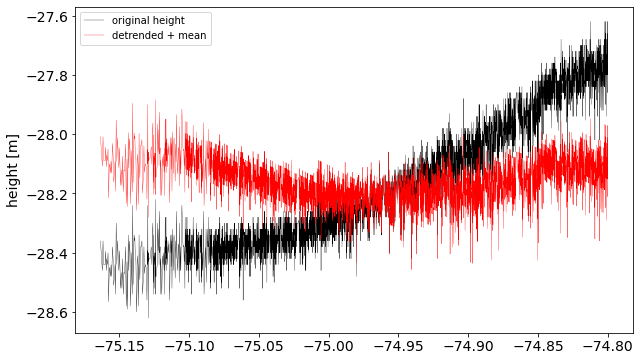

In [106]:
# check
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.tick_params(labelsize=14)
ax1.plot(ssh1['lat'], ssh1['h_estimate'],'-',linewidth=0.3,color='k', label='original height')
ax1.plot(ssh1['lat'], detrend_dim(ssh1['h_estimate'],'x') + ssh1['h_estimate'].mean(),'-',
         linewidth=0.3, color='r',label='detrended + mean')
ax1.set_ylabel('height [m]',fontsize=14);

ax1.legend(loc='upper left')
plt.show()

# function: normalize

In [135]:
def normalize(da):
    '''
    This function returns normalized dataarray as numpy
    i.e., unit variance and zero mean
    '''    
    return (da.data - np.nanmean(da.data)) / np.nanstd(da.data)

In [136]:
# check
ssh1_detrend = detrend_dim(ssh1['h_estimate'],'x')
ssh1_norm = normalize(ssh1_detrend)

In [138]:
ssh1_norm.mean()

2.4406792125722635e-17

In [139]:
ssh1_norm.std()

1.0

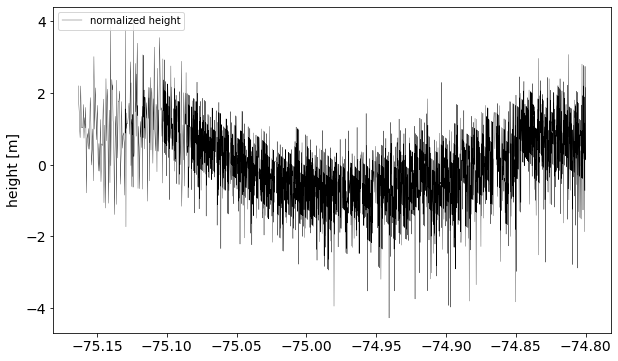

In [137]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.tick_params(labelsize=14)
ax1.plot(ssh1['lat'], ssh1_norm,'-',linewidth=0.3,color='k', label='normalized height')
ax1.set_ylabel('height [m]',fontsize=14);

ax1.legend(loc='upper left')
plt.show()

# function: cross correlation

In [144]:
from scipy import signal

In [165]:
def cross_corr(x,y):
    '''
    This function calculates cross correlation between v1 and v2.
    '''
    corr = signal.correlate(x, y)
    lags = signal.correlation_lags(len(x), len(y))
    corr /= np.max(corr)
    return corr,lags

In [166]:
# make up a thermal to check cross_corr
thermal = ssh1_norm*2+3+np.sin(len(ssh1_norm))
thermal_norm = (thermal - thermal.mean()) / np.std(thermal)

In [167]:
corr,lags = cross_corr(ssh1_norm,thermal_norm)

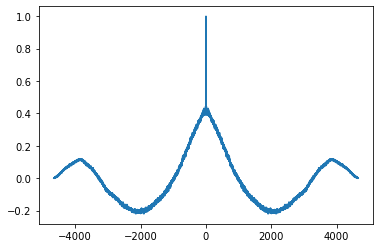

In [171]:
plt.plot(lags,corr)

# Try landsat import from Tasha

## search for landsat imagery
To explore and access COG's easily we will use a SpatioTemporal Asset Catalog (STAC). The STAC provides a common metadata format to make it easier to index and querrying S3 buckets for geospatial data. Learn more here: https://github.com/radiantearth/stac-spec.

In [34]:
# Sets up credentials for acquiring images through dask/xarray
os.environ["AWS_REQUEST_PAYER"] = "requester"

# Sets up proper credentials for acquiring data through rasterio
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [40]:
# Search for Landsat or Sentinel images based on a bounding box, date and other metadata if desired
# Save to geojson file
# NOTE this STAC API endpoint does not currently search the entire catalog

satellite = 'Landsat8'

bbox = (-105.0, -74.970, -105.08, -74.950) #(west, south, east, north) 

#timeRange = '2019-01-14/2019-01-15'
timeRange = '2019-04-15/2019-04-16'

if satellite=='Landsat8':
    # url = 'https://ibhoyw8md9.execute-api.us-west-2.amazonaws.com/prod'
    url = 'https://landsatlook.usgs.gov/stac-server'
    collection = 'usgs-landsat/collection02/'
    band = 'blue'
    colnm = ['landsat:wrs_path','landsat:wrs_row']
    end = '_T2' # end of file name if don't want all
    qa_band = 'qa_pixel'
elif satellite=='Sentinel2':
    url = 'https://earth-search.aws.element84.com/v0' # maybe also https://services.sentinel-hub.com/api/v1/catalog/
    collection = 'sentinel-s2-l2a-cogs'
    band = 'B02'
    colnm = ['sentinel:latitude_band','sentinel:grid_square']
    end = 'L2A'
    qa_band = 'SCL'
elif satellite=='Sentinel1': ### Doesn't work
    url = 'http://eocloud.sentinel-hub.com/search'
    collection = 'sentinel-s1-rtc-indigo'
    
results = Search.search(url=url,
                        collection=collection,
                        datetime=timeRange,
                        bbox=bbox,    
                        # properties=properties,
                        sort=['<datetime'])

print('%s items' % results.found())
items = results.items()
gjson_outfile = f'/home/jovyan/Polynyas/contributors/Tasha/{satellite}.geojson'
items.save(gjson_outfile)

AttributeError: type object 'Search' has no attribute 'search'